In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btc.csv')
print(df)

      Unnamed: 0 formatted_date          high           low          open  \
0              0     2019-01-01   3850.913818   3707.231201   3849.216309   
1              1     2019-01-02   3947.981201   3817.409424   3931.048584   
2              2     2019-01-03   3935.685059   3826.222900   3832.040039   
3              3     2019-01-04   3865.934570   3783.853760   3851.973877   
4              4     2019-01-05   3904.903076   3836.900146   3836.519043   
...          ...            ...           ...           ...           ...   
1515        1515     2023-02-24  24103.705078  23007.072266  23200.125000   
1516        1516     2023-02-25  23210.210938  22861.558594  23174.150391   
1517        1517     2023-02-26  23654.367188  23084.220703  23561.451172   
1518        1518     2023-02-27  23857.890625  23205.878906  23521.837891   
1519        1519     2023-02-28  23585.384766  23077.650391  23150.929688   

             close       volume      adjclose  
0      3843.520020   432420

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,3608.840820,3558.537109,3575.081299,3576.032471,5004347059,3576.032471,50.303711,3646.814279,3705.745762,3776.614490,50.412745,165.766144
21,21,2019-01-22,3620.746582,3539.721436,3605.557129,3604.577148,5313623556,3604.577148,81.025146,3643.085972,3675.297852,3765.236258,52.717606,169.110917
22,22,2019-01-23,3623.067871,3565.313965,3584.500244,3585.123047,5433755649,3585.123047,57.753906,3633.102574,3643.142613,3748.175002,56.560870,168.308098
23,23,2019-01-24,3616.087402,3569.092773,3607.390381,3600.865479,5262869046,3600.865479,46.994629,3622.002790,3637.566964,3736.942825,53.704202,169.964561
24,24,2019-01-25,3612.927734,3575.597412,3599.715332,3599.765869,5265847539,3599.765869,37.330322,3613.706578,3631.309849,3724.659412,51.693454,170.120767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,24103.705078,23007.072266,23200.125000,23198.126953,26811744928,23198.126953,1096.632812,24224.126395,23553.841936,23260.729632,536.387413,1085.510059
1516,1516,2023-02-25,23210.210938,22861.558594,23174.150391,23175.375000,16100721565,23175.375000,348.652344,24014.711775,23647.020508,23253.278553,625.186896,1085.534512
1517,1517,2023-02-26,23654.367188,23084.220703,23561.451172,23561.212891,16644534842,23561.212891,570.146484,23905.221819,23773.664062,23282.114118,628.353819,1085.276291
1518,1518,2023-02-27,23857.890625,23205.878906,23521.837891,23522.871094,22660763494,23522.871094,652.011719,23718.610770,23896.147600,23318.436105,486.099617,1079.681956


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.2)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.1)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

150
(1343, 7, 9) (1343, 1) (150, 7, 9) (150, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 9s 12ms/step - loss: 0.0274
Epoch 2/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 3/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 4/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0048
Epoch 5/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0040
Epoch 6/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 7/120
40/40 [==============================] - 1s 15ms/step - loss: 0.0039
Epoch 8/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0031
Epoch 9/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 10/120
40/40 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 11/120
40/40 [==============================] - 1s 14ms/step - loss: 0.0031
Epoch 12/120
40/40 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 13/120
40/40 [=====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

42/42 [==============================] - 2s 3ms/step
      predict_price  y_train_price  error_price
0       4569.973633    3470.450439  1099.523193
1       4517.066895    3448.116943  1068.949951
2       4453.802734    3486.181641   967.621094
3       4439.269043    3457.792725   981.476318
4       4440.201172    3487.945312   952.255859
...             ...            ...          ...
1338   19198.308594   19110.546875    87.761719
1339   19479.537109   19426.720703    52.816406
1340   19457.681641   19573.050781  -115.369141
1341   19579.072266   19431.789062   147.283203
1342   19765.712891   19312.095703   453.617188

[1343 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

5/5 [==============================] - 0s 3ms/step
[[0.2526922 ]
 [0.24853382]
 [0.25092888]
 [0.25961965]
 [0.2623098 ]
 [0.26178178]
 [0.25591555]
 [0.2516119 ]
 [0.2505317 ]
 [0.2479763 ]
 [0.24490067]
 [0.24483265]
 [0.24489811]
 [0.24925382]
 [0.24808094]
 [0.24880949]
 [0.25145468]
 [0.2509596 ]
 [0.24843305]
 [0.24634604]
 [0.2453627 ]
 [0.24678063]
 [0.2503361 ]
 [0.25033   ]
 [0.25694063]
 [0.26789322]
 [0.26833794]
 [0.26780647]
 [0.27125925]
 [0.27086538]
 [0.26816243]
 [0.26734883]
 [0.26525214]
 [0.26371935]
 [0.2715048 ]
 [0.2789574 ]
 [0.27734712]
 [0.27156717]
 [0.2476227 ]
 [0.21470128]
 [0.2137399 ]
 [0.21415284]
 [0.21114342]
 [0.20616691]
 [0.20587437]
 [0.21125513]
 [0.21223742]
 [0.21113977]
 [0.21161145]
 [0.21123242]
 [0.20737812]
 [0.19982958]
 [0.19939445]
 [0.20507047]
 [0.20883639]
 [0.20815381]
 [0.2072523 ]
 [0.2063468 ]
 [0.20290397]
 [0.20332247]
 [0.21117964]
 [0.21507889]
 [0.2158603 ]
 [0.21464662]
 [0.21504398]
 [0.21518499]
 [0.21509987]
 [0.2136262

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[19794.014]
 [19527.182]
 [19680.865]
 [20238.53 ]
 [20411.148]
 [20377.268]
 [20000.848]
 [19724.693]
 [19655.38 ]
 [19491.406]
 [19294.053]
 [19289.686]
 [19293.889]
 [19573.38 ]
 [19498.121]
 [19544.871]
 [19714.605]
 [19682.838]
 [19520.715]
 [19386.797]
 [19323.7  ]
 [19414.684]
 [19642.83 ]
 [19642.438]
 [20066.625]
 [20769.424]
 [20797.959]
 [20763.857]
 [20985.412]
 [20960.139]
 [20786.697]
 [20734.49 ]
 [20599.953]
 [20501.598]
 [21001.168]
 [21479.383]
 [21376.055]
 [21005.17 ]
 [19468.717]
 [17356.236]
 [17294.547]
 [17321.045]
 [17127.938]
 [16808.607]
 [16789.836]
 [17135.107]
 [17198.137]
 [17127.705]
 [17157.97 ]
 [17133.65 ]
 [16886.328]
 [16401.959]
 [16374.038]
 [16738.254]
 [16979.902]
 [16936.104]
 [16878.256]
 [16820.15 ]
 [16599.234]
 [16626.088]
 [17130.264]
 [17380.467]
 [17430.61 ]
 [17352.729]
 [17378.227]
 [17387.275]
 [17381.812]
 [17287.254]
 [17430.768]
 [17545.373]
 [17552.758]
 [17513.424]
 [17456.121]
 [17829.412]
 [18214.742]
 [17989.469]
 [17420.242]

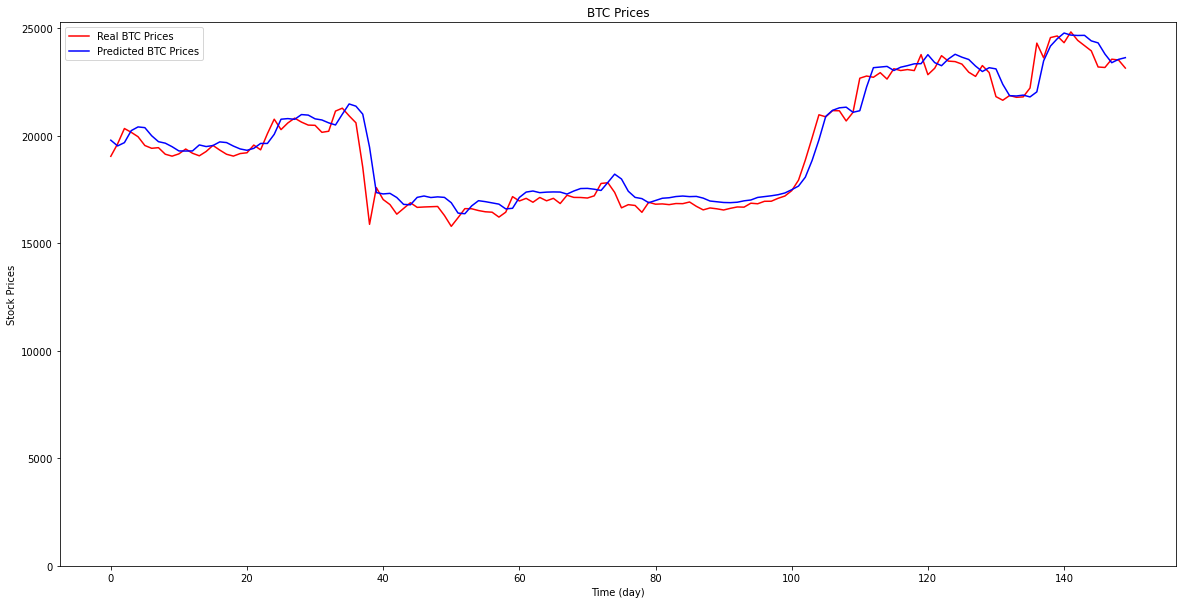

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real BTC Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 436.73
MAPE: 2.29%
MSE: 386052.35
RMSE: 621.33
R2: 0.95


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))